# Jonathan Forhan EE-201

## Colab

https://colab.research.google.com/drive/1hPysLn-NzOry_pon9vGoteV-FjQcptcA?authuser=0#scrollTo=hJlHCoYv_rFQ

## CSV Schema

uses original CSV files

|Entry              |Datatype        |
|:------------------|:---------------|
|Memory Length      |int             |
|Trigger Level      |float           |
|Source             |str             |
|Probe              |str             |
|Vertical Units     |str             |
|Vertical Scale     |float           |
|Vertical Position  |float           |
|Horizontal Units   |str             |
|Horizontal Scale   |float           |
|Horizontal Position|float           |
|Horizontal Mode    |str             |
|Samping Period     |float           |
|Firmware           |str             |
|Time               |str             |
|Mode               |str             |
|Waveform Data      |list[int]|

(Headersize: 16 entries)

## Legend

|Plot            |Color    |
|:---------------|:--------|
|Measured Input  |Orange   |
|Measured Output |Green    |
|Simulated Input |Red      |
|Simulated Output|Blue     |

## Resources

https://www.gwinstek.com/en-global/products/downloadSeriesDownNew/12088/1042

In [193]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

HEADER_SIZE = 16
PROBE_10X = 10     # this oscilloscope is 10X probe so to see true value to multiply by 10
SIM_OFFSET = 980   # offset needed to match start of simulation
CH1_PATH = './res/A0029CH1.CSV'
CH2_PATH = './res/A0029CH2.CSV'
SIM_PATH = './res/oscilloscope_data_project_sim.csv'


# oscilloscope data is is int format, need to uncompress
def scale_8bit(n) -> float:
    return float(n) / 256  # byte to float


# I'd rather not manipulate the csv files so I read them in by hand
def populate_channel(path: str) -> dict:
    channel = {}

    with open(path, mode='r') as f:
        csv_file = csv.reader(f)

        for i, line in enumerate(csv_file):
            if i < HEADER_SIZE:
                # the last header 'Waveform Data' is a special case, I want to make it a list
                channel[line[0]] = line[1] if i != HEADER_SIZE-1 else []
            else:
                channel['Waveform Data'].append(scale_8bit(line[0]) * PROBE_10X)

    return channel


# debug info
def print_header(channel: dict):
    print('----------------')
    [print(k, ':', channel[k]) for k in list(channel)[:HEADER_SIZE-1]]


# accepts ax so could be plt or a subplot ax
def generate_channel_plot(channel: dict, ax, io):
    h_scale = float(channel['Horizontal Scale'])
    v_scale = float(channel['Vertical Scale'])
    mem_len = int(channel['Memory Length'])

    # scrub_data does 2 things
    # 1) scales the data to proper dimensions as per CSV header scaling
    # 2) removes the excess idle data in front to match the start of simulated data (to make visual comparison easier)
    def scrub_data(x, y):
        x = [n * h_scale for n in x][SIM_OFFSET:]   # scale and trim simulation offset
        x = list(map(lambda n, t=x[0]: n - t, x))   # need to account for the offset, x[0] is the new start time
        y = [n * v_scale for n in y][SIM_OFFSET:]   # scale and trim simulation offset
        return (x, y)

    x = np.linspace(0, scale_8bit(mem_len), mem_len)
    y = channel['Waveform Data']
    x, y = scrub_data(x, y)
    if io == 'input':
        line, = ax.plot(x, y, 'orange')
        return line
    elif io == 'output':
        line, = ax.plot(x, y, 'green')
        return line
    else:
        raise Exception('Must enter io [input|output]')


# accepts ax so could be plt or a subplot ax
def generate_simulation_plot(simulation, ax, io):
    if io == 'input':
        x_in = simulation.columns[0]
        y_in = simulation.columns[1]
        x = simulation[x_in].to_numpy()
        y = simulation[y_in].to_numpy()
        line, = ax.plot(x, y, 'red')
        return line
    elif io == 'output':
        x_out = simulation.columns[3]
        y_out = simulation.columns[4]
        x = simulation[x_out].to_numpy()
        y = simulation[y_out].to_numpy()
        line, = ax.plot(x, y, 'blue')
        return line
    else:
        raise Exception('Must enter io [input|output]')


# populate unfriendly csv by hand
channel1 = populate_channel(CH1_PATH)
print_header(channel1)
channel2 = populate_channel(CH2_PATH)
print_header(channel2)

# populate friendly csv with pandas
simulation = pd.read_csv(SIM_PATH)

----------------
Memory Length : 4000
Trigger Level : 6.400E-01
Source : CH1
Probe : 10X
Vertical Units : V
Vertical Scale : 2.000E-01
Vertical Position : -6.320E-01
Horizontal Units : s
Horizontal Scale : 2.500E-04
Horizontal Position : 1.010E-03
Horizontal Mode : Main
Sampling Period : 1.000E-06
Firmware : V1.13
Time :  
Mode : Fast
----------------
Memory Length : 4000
Trigger Level : 6.400E-01
Source : CH2
Probe : 10X
Vertical Units : V
Vertical Scale : 2.000E-01
Vertical Position : -6.400E-01
Horizontal Units : s
Horizontal Scale : 2.500E-04
Horizontal Position : 1.010E-03
Horizontal Mode : Main
Sampling Period : 1.000E-06
Firmware : V1.13
Time :  
Mode : Fast


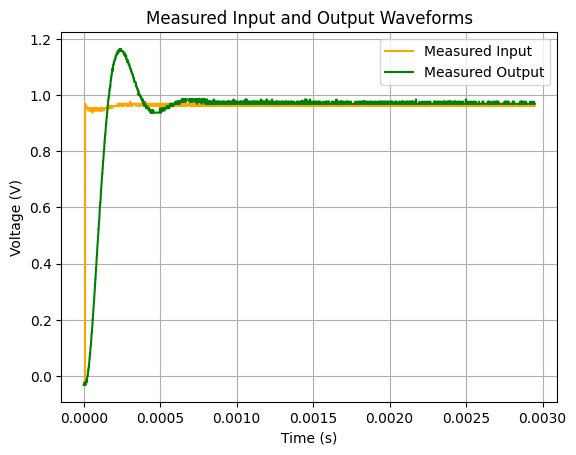

In [188]:
title = 'Measured Input and Output Waveforms'

plt.title(title)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
generate_channel_plot(channel1, plt, io='input').set_label('Measured Input')
generate_channel_plot(channel2, plt, io='output').set_label('Measured Output')
plt.legend(loc="best")

plt.savefig(title + '.png')

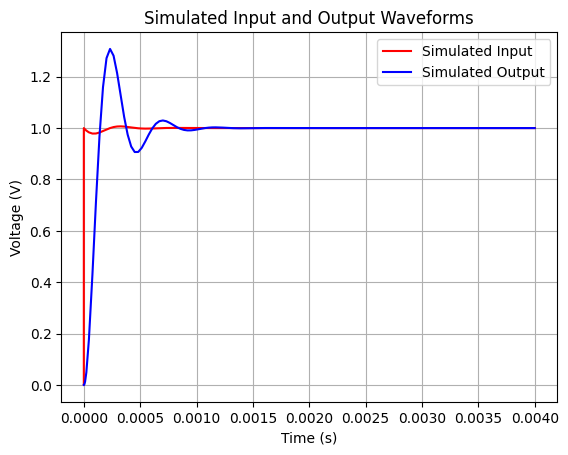

In [194]:
title = 'Simulated Input and Output Waveforms'

plt.title(title)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
generate_simulation_plot(simulation, plt, io='input').set_label('Simulated Input')
generate_simulation_plot(simulation, plt, io='output').set_label('Simulated Output')
plt.legend(loc='best')

plt.savefig(title + '.png')

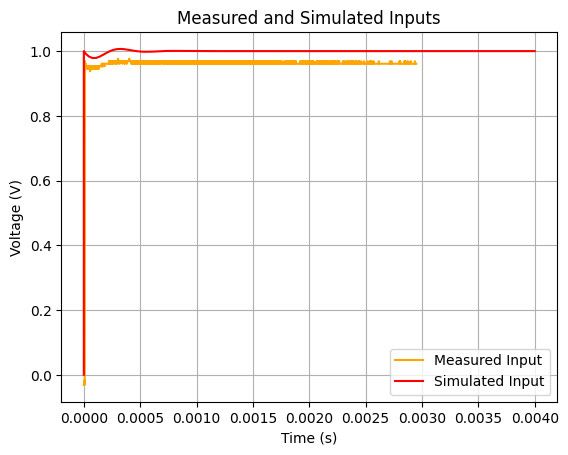

In [195]:
title = 'Measured and Simulated Inputs'

plt.title(title)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
generate_channel_plot(channel1, plt, io='input').set_label('Measured Input')
generate_simulation_plot(simulation, plt, io='input').set_label('Simulated Input')
plt.legend(loc='best')

plt.savefig(title + '.png')

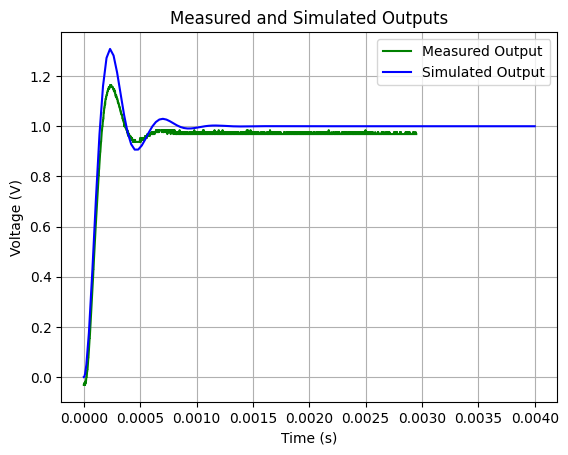

In [196]:
title = 'Measured and Simulated Outputs'

plt.title(title)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
generate_channel_plot(channel2, plt, io='output').set_label('Measured Output')
generate_simulation_plot(simulation, plt, io='output').set_label('Simulated Output')
plt.legend(loc='best')

plt.savefig(title + '.png')

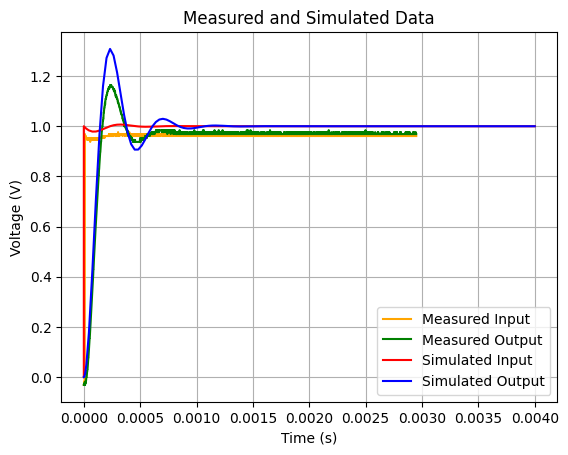

In [197]:
title = 'Measured and Simulated Data'

plt.title(title)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
generate_channel_plot(channel1, plt, io='input').set_label('Measured Input')
generate_channel_plot(channel2, plt, io='output').set_label('Measured Output')
generate_simulation_plot(simulation, plt, io='input').set_label('Simulated Input')
generate_simulation_plot(simulation, plt, io='output').set_label('Simulated Output')
plt.legend(loc='best')

plt.savefig(title + '.png')